In [4]:
import torch
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from models.fair import BinaryFair
from models.flow import Flow
from models.classifier import BinaryClassifier
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.metrics import accuracy_score
from tqdm.auto import trange

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
data_file = torch.load("data/Crime/data.pt")

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


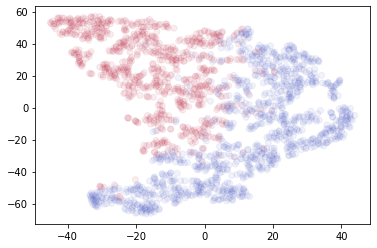

In [69]:
X_embedded = TSNE(n_components=2).fit_transform(data_file['data'])
plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.07, cmap='coolwarm')

In [40]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

# Split data by label
data_0 = data_file['data'][data_file['context'].flatten() == 0]
labels_0 = data_file['labels'][data_file['context'].flatten() == 0]

data_1 = data_file['data'][data_file['context'].flatten() == 1]
labels_1 = data_file['labels'][data_file['context'].flatten() == 1]

# Generators
label_0_set = TensorDataset(data_0, labels_0)
label_0_generator = torch.utils.data.DataLoader(label_0_set, **params)

label_1_set = TensorDataset(data_1, labels_1)
label_1_generator = torch.utils.data.DataLoader(label_1_set, **params)


In [83]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

# Generators
data_set = TensorDataset(data_file['data'], data_file['context'])
data_generator = torch.utils.data.DataLoader(data_set, **params)

In [84]:
data_file['data'].shape

torch.Size([1994, 6])

In [85]:
probability_flow = Flow(data_dim=data_file['data'].shape[1], context_dim=data_file['context'].shape[1])
optimizer = torch.optim.AdamW(probability_flow.parameters(), lr=1e-3, weight_decay=1e-4)
losses = []

In [86]:
n_steps = 1000
# probability_flow.train()
for n_step in trange(n_steps):
    data, context = next(iter(data_generator))
    
    optimizer.zero_grad()

    loss = -probability_flow.log_prob(inputs=data, context=context).mean()
    losses.append(loss.item())
    loss.backward()
    optimizer.step()


100%|██████████| 1000/1000 [00:03<00:00, 307.24it/s]


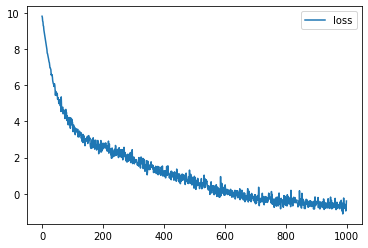

In [87]:
plt.plot(losses, label="loss")
xlims = plt.xlim()
ylims = plt.ylim()
plt.legend()
plt.show()

In [115]:
data, context = next(iter(data_generator))
data_embedded = TSNE(n_components=2).fit_transform(data)
samples = probability_flow._sample(num_samples=1, context=context)

#? How to vizualize output of probability_flow?

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [123]:
out_embedded = TSNE(n_components=2).fit_transform(samples.flatten(start_dim=1).detach().numpy())

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


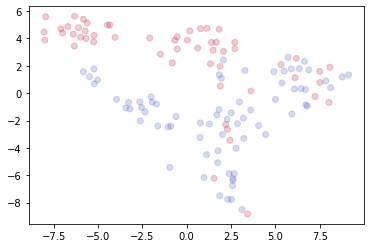

In [127]:
plt.scatter(*out_embedded.T, c=context, alpha=0.2, cmap='coolwarm')

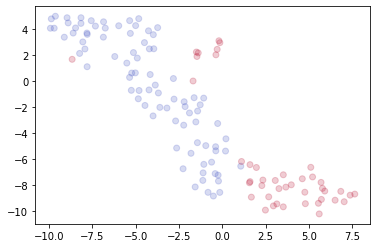

In [98]:
plt.scatter(*data_embedded.T, c=context, alpha=0.2, cmap='coolwarm')

In [44]:
gamma = 0.2
Fair = BinaryFair(data_dim=data_file['data'].shape[-1], 
                  context_dim=None, 
                  flow_n_layers = 3,
                  flow_transform_type = 'MaskedAffineAutoregressiveTransform', 
                  classifier_hidden_dim = 32,
                  classifier_n_layers = 4,
                  classifier_activation = 'ReLU',
                  gamma=gamma
                 )
optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-3, weight_decay=1e-4)
total_losses = []
KL_losses = []
clf_losses = []

In [54]:
n_steps = 500
Fair.train()
for n_step in trange(n_steps):
    data_0, labels_0 = next(iter(label_0_generator))
    data_1, labels_1 = next(iter(label_1_generator))
    
    optimizer.zero_grad()

    L_KL, L_clf, loss = Fair.loss(data_0, data_1, labels_0=labels_0, labels_1=labels_1, return_all_losses=True)

    total_losses.append(loss.item())
    KL_losses.append(L_KL.item())
    clf_losses.append(L_clf.item())

    loss.backward()
    optimizer.step()
# Fair.eval()

100%|██████████| 500/500 [00:09<00:00, 52.06it/s]


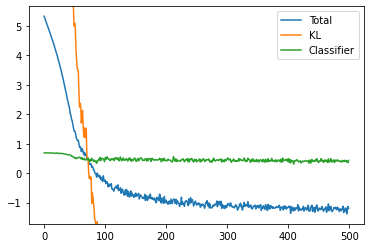

In [7]:
plt.plot(total_losses, label="Total")
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot(KL_losses, label="KL")
plt.plot(clf_losses, label="Classifier")
plt.legend()
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.show()

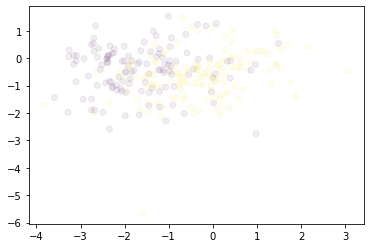

In [72]:
data_0, labels_0 = next(iter(label_0_generator))
data_1, labels_1 = next(iter(label_1_generator))

embedding_0, embedding_1 = Fair._embed(data_0, data_1, context_0=None, context_1=None)

plt.scatter(*embedding_0.T[:2].detach(), alpha=0.07, c=labels_0)
plt.scatter(*embedding_1.T[:2].detach(), alpha=0.07, c=labels_1)


In [9]:
with torch.no_grad():
    cont_pred = Fair(data_file['data'], data_file['context'])
    bin_pred = (cont_pred > 0.5).int()
    acc = accuracy_score(bin_pred, data_file['labels'])
acc

0.802407221664995

Accuracies:
    gamma = 0. : 0.84  # paper achieves 85.2 (not too far off)
    gamma = 1. : 0.5

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


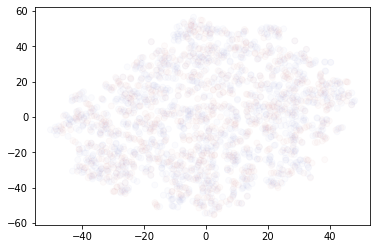

In [10]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx]
    )
    embedding = torch.cat([embedding_0, embedding_1])
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
plt.scatter(*X_embedded.T, c=data_file["context"], alpha=0.02, cmap="coolwarm")


In [11]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx]
    )

EmpiricalStatisticalDistance(
    embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100
)


100%|██████████| 100/100 [00:06<00:00, 14.87it/s]

Training set accuracy: 0.861
Test set accuracy: 0.802


tensor(0.4824, grad_fn=<AbsBackward0>)